In [26]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
from scipy.integrate import quad
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import algopy
from algopy import UTPM, exp
import copy
import calendar
from optimise_GDD_fctns import Phenology_set, run_GDD_and_get_RMSE, run_GDD_and_get_RMSE_derivs, plot_profiles_at_minimum, get_station_locations, put_ERA5_in_array

#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [27]:
def Wang_Engel_Integral(T, T_min, T_opt, T_max):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_1 = (2*(np.sign(T - T_min)*(T - T_min))**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2 = ((np.sign(T - T_min)*(T - T_min))**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T = ( f_1 - f_2 ) / ((T_opt - T_min)**(2*alpha))
    f_T = np.nan_to_num(f_T)

    f_1_max = (2*(T_max - T_min)**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2_max = ((T_max - T_min)**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T_max = ( f_1_max - f_2_max ) / ((T_opt - T_min)**(2*alpha))
    return f_T*(T >= T_min)*(T<= T_max) + f_T_max*(T > T_max)
    
def Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = 4):
    return (1/(2*gap))*(Wang_Engel_Integral(np.minimum(T + gap, T_max), T_min, T_opt, T_max) - Wang_Engel_Integral(np.maximum(T - gap, T_min), T_min, T_opt, T_max))#
    
def integrand(T, T_min, T_opt, T_max, d, s, gap):
    #return modelling_fctns.Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1.5)*np.exp(-((T - d)**2)/(2*(s**2)))
    return Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = gap)*(1/np.sqrt(2*np.pi*(s**2)))*np.exp(-((T - d)**2)/(2*(s**2)))
    
def expint(T_min, T_opt, T_max, d, s, gap):
    return quad(integrand, T_min, T_max, args=(T_min, T_opt, T_max, d, s, gap))[0]
vec_expint = np.vectorize(expint)

In [28]:
def run_GDD_and_get_RMSE(x, ds, driver_variable, latlon_proj = True, 
                         response_type = 'Trapezoid', phase_list = ['beginning of flowering'], 
                         new_unfinished_penalisation=False,
                         growing_period_length = 300, thresholds = [100]):
    if response_type == 'Trapezoid':
        def response(meantemp):
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
    elif response_type == 'Convolved':
        table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 2.5, 5)#, x[4], x[5])#x[2]
        def response(meantemp):
            return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
    elif response_type == 'Spline2':
        spl = scipy.interpolate.BSpline(np.arange(0, 40, 4), np.array(x), 3)
        def response(meantemp):
            return np.maximum(spl(meantemp), 0)
    elif response_type == 'Spline':
        def B_0(u):
            return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)
        def response(meantemp):
            resp = 0
            for i, coeff in enumerate(x):
                resp += coeff*B_0(0.25*(meantemp - i*2))
            return np.maximum(resp, 0)
    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    
    #Run model
    for day in range(growing_period_length):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}']
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        t_dev += response(driver_values)#, t_dev)
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    unfinished_penalty=0
    if new_unfinished_penalisation:
        unfinished_penalty = max((comparison_array[f'modelled time to {phase_list[0]}'] >growing_period_length - 3).sum() - 0.03*comparison_array.shape[0], 0)
        comparison_array = comparison_array.where(comparison_array[f'modelled time to {phase_list[0]}'] < growing_period_length).dropna()
    def RMSE(residuals):
        if len(residuals) == 0:
            return 0
        else:
            return np.sqrt(np.mean(residuals**2))
    residuals = np.concatenate([(comparison_array[f'observed time to {phase}'].dt.days - comparison_array[f'modelled time to {phase}']).values for phase in phase_list])
    return RMSE(residuals) + unfinished_penalty#, comparison_array


In [29]:
def run_GDD_and_get_RMSE_derivs(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid', 
                                phase_list = ['beginning of flowering'],growing_period_length = 300,
                                thresholds = [100]):
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
    elif response_type == 'Spline':
        def B_0(u):
            return 0.1*((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)
        def response(meantemp):
            resp = 0
            for i, coeff in enumerate(x):
                resp += coeff*B_0(0.25*(meantemp - i*2))
            return np.maximum(resp, 0)
        def deriv(meantemp):
            return [B_0(0.25*(meantemp - i*2)) for i in range(len(x))]
    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    accumulated_deriv_time_series = [[t_dev.copy()] for count in range(len(x))]
    dev_time_series = [t_dev.copy()]
    list_of_responses = [] 
    #Run model
    for day in range(growing_period_length):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}'].values
        resp = response(driver_values)
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        if response_type == 'Trapezoid':
            response_deriv = x[0]*Trapezoid_Temp_derivs(driver_values, x[1], x[2], x[3], x[4])
            response_deriv[0, :] = response_deriv[0, :]/x[0]
        elif response_type == 'Wang':
            response_deriv_no_scale = Wang_Temp_Derivs(driver_values, x[1], x[2], x[3])
            response_deriv = [resp/x[0]] + [x[0]*deriv for deriv in response_deriv_no_scale]
        elif response_type == 'Spline':
            response_deriv = deriv(driver_values)
        for x_index in range(len(x)):
            accumulated_deriv_time_series[x_index].append(accumulated_deriv_time_series[x_index][-1] + response_deriv[x_index])
            #print(response_deriv[x_index])
        t_dev += resp#, t_dev)
        list_of_responses.append(resp)
        #print(len(accumulated_deriv_time_series[0][-1]))
        #print(accumulated_deriv_time_series[0][-1], t_dev/x[0])
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())
    #print(accumulated_deriv_time_series[2][100])

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    resps_list = np.zeros(model_dev_time_series.shape[1])
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64)) - 1
        resps_list[obs_index] = list_of_responses[int(phase_dates_array[-1, obs_index]) - 1][obs_index].mean()
    if response_type == 'Spline':
        resps_list += 50000*(resps_list == 0)
    else:
        resps_list += 0.1*x[0]*(resps_list == 0)
    print(resps_list)
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names).astype('int64')
    for x_index in range(len(x)):
        accumulated_derivs = accumulated_deriv_time_series[x_index]
        accumulated_derivs.append(ds['Referenzjahr'].values)
        accumulated_derivs.append(ds['Stations_id'].values)
        #print(accumulated_derivs[300])
        for phase in phase_list:
            accumulated_derivs.append(np.array(accumulated_derivs).T[np.arange(len(ds)), phase_dates_array[f'modelled time to {phase}'].values])
        #print(accumulated_derivs)
        column_names = np.array(['Referenzjahr', 'Stations_id'] + [f'x{x_index} deriv for {phase}'])
        #print(np.array(accumulated_derivs[301]))
        if x_index == 0:
            #derivs_array1 = pd.DataFrame(np.array(accumulated_derivs[301:]).T, columns = column_names)
            derivs_array = pd.DataFrame(np.array(accumulated_derivs[(growing_period_length + 1):]).T, columns = column_names)
            #print(derivs_array.shape)
        else:
            derivs_array2 = pd.DataFrame(np.array(accumulated_derivs[(growing_period_length + 1):]).T, columns = column_names)
            derivs_array = derivs_array.merge(derivs_array2, how='left', on=['Referenzjahr', 'Stations_id'])
            #print(derivs_array.shape)
    #print(derivs_array.loc[np.isnan(derivs_array['x10 deriv for beginning of flowering'])])
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    comparison_array = comparison_array.merge(derivs_array, on=['Referenzjahr', 'Stations_id'])
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    residuals = np.concatenate([(comparison_array[f'observed time to {phase}'].dt.days - comparison_array[f'modelled time to {phase}']).values for phase in phase_list])
    error = RMSE(residuals)
    #print(len(residuals), len(comparison_array))
    #print(residuals)
    deriv_list = [
        -((comparison_array[f'modelled time to {only_phase}'] - comparison_array[f'observed time to {only_phase}'].dt.days)*
         comparison_array[f'x{xindex} deriv for {only_phase}']/resps_list).mean()/error for xindex in range(len(x))#x[0]
         #(comparison_array['modelled time to yellow ripeness']/(1 + comparison_array[f'x{xindex} deriv for yellow ripeness']) - comparison_array['modelled time to yellow ripeness'])).sum() for xindex in range(len(x))
    ]
    return deriv_list#, derivs_array#, resps_list#, comparison_array#, comparison_array, derivs_array, accumulated_deriv_time_series#, resps_list#, comparison_array, phase_dates_array, derivs_array, derivs_array2, derivs_array1


27.3
28.0


Text(0.5, 1.0, 'Normal temperature response versus temperature response modified for larger scale')

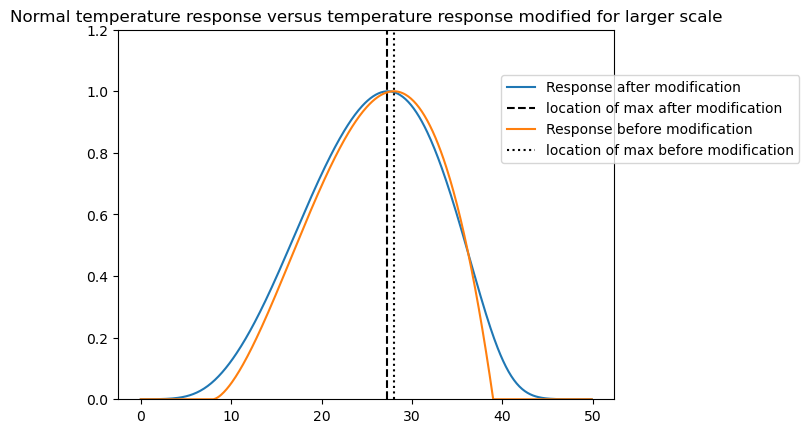

In [39]:
#%matplotlib inline
fig, ax = plt.subplots()
meantemp = np.arange(0, 50, 0.1)
plotvals = vec_expint(8, 28, 39, meantemp, 2.5, 5)
maxloc = plotvals.argmax()
maxval = meantemp[maxloc]
print(maxval)
ax.plot(meantemp, plotvals/(plotvals.max()), label = 'Response after modification')
ax.axvline(maxval, color = 'black', label = 'location of max after modification', linestyle = '--')
unconvolved = modelling_fctns.Wang_Engel_Temp_response(meantemp, 8, 28, 39)
maxloc = unconvolved.argmax()
maxval = meantemp[maxloc]
print(maxval)
ax.plot(meantemp, unconvolved/unconvolved.max(), label = 'Response before modification')
ax.axvline(maxval, color = 'black', label = 'location of max before modification', linestyle = ':')
meantemp = np.arange(0, 49, 0.1)
fig.legend(bbox_to_anchor = (1.2, 0.8))
ax.set_ylim((0, 1.2))
ax.set_title('Normal temperature response versus temperature response modified for larger scale')
#ax.plot(meantemp, table[(np.round(meantemp/5, decimals = 1)*10).astype(int)])#Convolved_Wang_Engel(np.arange(0, 50, 0.5), 8, 28, 39, gap = 5))

In [105]:
phen_data_CIMMYT = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\with_SOS\\CIMMYT_phen_data.csv')
phen_data_CIMMYT = dataset_fctns.columns_to_datetime(phen_data_CIMMYT, ['PlantingDate', 'AnthesisDate', 'DaysToSilk'])
phen_data_CIMMYT = phen_data_CIMMYT.rename(columns={'AnthesisDate': 'observed time to beginning of flowering'})
phen_data_CIMMYT = dataset_fctns.prepare_African_phen_ds(phen_data_CIMMYT, 'beginning of flowering', reducer = 'max')#'PlantingDate', 
phen_data_CIMMYT['WC SOS date'] = pd.to_datetime(phen_data_CIMMYT['PlantingDate'].dt.date)
phen_data_CIMMYT = phen_data_CIMMYT.loc[(phen_data_CIMMYT['observed time to beginning of flowering'] - phen_data_CIMMYT['WC SOS date']).dt.days < 240]
phen_data_CIMMYT['pd'] = pd.to_datetime(phen_data_CIMMYT['PlantingDate'].dt.date)
phen_data_CIMMYT['Referenzjahr'] = phen_data_CIMMYT['yrcode']

yes


In [3]:
Maize_set_Africa = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\maizedata.lobell.sep2011.csv', raw = False, dwd_data=False)
Maize_set_Africa.phen_data = phen_data_CIMMYT
Maize_set_Africa.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\Africa\\ERA5_SSA_1999_2009.nc')
Maize_set_Africa.phen_data['Eintrittsdatum'] = Maize_set_Africa.phen_data['PlantingDate']
#Maize_set_Africa.phen_data['Stations_id'] = Maize_set_Africa.phen_data['sitecode']
Maize_set_Africa.make_input_array(latlon_proj=True)

project to new coords
interpolate driver to station locations


In [4]:
#Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", raw = True)
Maize_set = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv', raw = False)
Maize_set.drop_columns(['Unnamed: 9', 'Unnamed: 0'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])

Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2011_2024.nc') #C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array(latlon_proj=True)
#Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.where(Maize_set.GDD_driver_data['time'] >= np.datetime64('2012-01-01'), drop = True)
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
Maize_set.make_input_array(latlon_proj=True)
Maize_set.phase_list = ['beginning of emergence', 'beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()

Column Unnamed: 9 not found
project to new coords
interpolate driver to station locations


In [ ]:
phen_data_after_97 = Maize_set_Africa.phen_data.loc[Maize_set_Africa.phen_data['WC SOS date'] >= np.datetime64('1999-01-01')]
ds = put_temp_values_in_frame(Maize_set_Africa.GDD_driver_data, phen_data_after_97, 't2m', phase_list = ['beginning of flowering'],
                               SOS_offset=0, station_locations=False)#, dad, otu 
#ds1 = ds1.dropna(subset = ['temperature at day 0', 'observed time to yellow ripeness']).drop_duplicates()#
ds['observed time to beginning of flowering'] = ds['observed time to beginning of flowering'] - ds['WC SOS date']
ds = ds.where((ds['observed time to beginning of flowering'].dt.days > 0) & (ds['observed time to beginning of flowering'].dt.days < 120)).dropna()
#ds = ds1
#ds1 = put_ERA5_in_array(ds1)

In [ ]:
ds1 = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', phase_list = ['yellow ripeness'],
                               SOS_offset=0, station_locations=Maize_set.station_data, start_year = 2001)
#ds1 = ds1.dropna(subset = ['temperature at day 0', 'observed time to yellow ripeness']).drop_duplicates()#
ds1 = ds1.where(ds1['observed time to yellow ripeness'].dt.days > 50).dropna()
ds1 = put_ERA5_in_array(ds1)
ds2 = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', phase_list = ['yellow ripeness'],
                               SOS_offset=12, station_locations=Maize_set.station_data)
#ds2['WC SOS date'] = ds2['WC SOS date']# +np.timedelta64(12, 'D')
ds2 = ds2.where(ds2['observed time to yellow ripeness'].dt.days > 50).dropna()
ds2 = put_ERA5_in_array(ds2)


In [ ]:
ds_DE = put_temp_values_in_frame(Maize_set.GDD_driver_data, Maize_set.ds_observed, 't2m', phase_list = ['beginning of flowering'],
                              SOS_offset=0, station_locations=Maize_set.station_data, start_year=2001)
ds_DE = ds_DE.where(ds_DE['observed time to beginning of flowering'].dt.days > 30).dropna()
ds_DE = put_ERA5_in_array(ds_DE)
#print(ds['observed time to beginning of flowering'].dt.days.std(), 
#      ds1['observed time to yellow ripeness'].dt.days.std(), 
#      ds2['observed time to yellow ripeness'].dt.days.std())

In [27]:
print(ds['observed time to beginning of flowering'].std(),
        ds_DE['observed time to beginning of flowering'].std())

9 days 16:33:15.253681489 10 days 09:22:14.519524516


<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

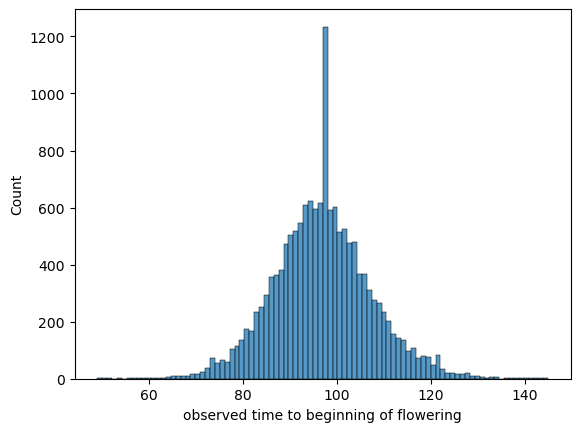

In [9]:
sns.histplot(ds_DE['observed time to beginning of flowering'].dt.days)

In [33]:
warm_threshold = 10
ds1_warm = ds1.loc[ds1['ERA5 clim'] > warm_threshold]
ds2_warm = ds2.loc[ds2['ERA5 clim'] > warm_threshold]
ds_warm = ds.loc[ds['ERA5 clim'] > warm_threshold]
ds1_cold = ds1.loc[ds1['ERA5 clim'] <= warm_threshold]
ds2_cold = ds2.loc[ds2['ERA5 clim'] <= warm_threshold]
ds_cold = ds.loc[ds['ERA5 clim'] <= warm_threshold]

In [135]:
print(ds1_warm['observed time to yellow ripeness'].dt.days.std(), ds2_warm['observed time to yellow ripeness'].dt.days.std(), ds_warm['observed time to beginning of flowering'].dt.days.std())

14.344866753121218 14.344866753121218 10.246885166016233


In [11]:
def local_opt(x1s, ds, lower_bounds = [0.05, 4, 20, 20, 35], upper_bounds = [1, 12, 35, 35, 60], 
              great_threshold = 13, response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
              method = 'trust-constr', modified_cost = False, thresholds = [100], growing_period_length = 185,
              maxiter = 50, split = True, test_size = 0.5, random_state=1):
    if split:
        train, test = train_test_split(ds, test_size=test_size, random_state = random_state)
    else:
        train = ds
        test = ds
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[4] - x[3]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0],
                                                [0, 0, -1, 1, 0],
                                                [0, 0, 0, -1, 1]])}
        constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
    elif response_type == 'Wang' or response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0, 0], [0, 0, -1, 1, 0, 0]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Spline':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2],
                                                x[3]]),
                    'jac' : lambda x: np.array([[0 for count in range(20)],
                                                [0 for count in range(20)]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0 for count in range(20)], [0 for count in range(20)]]),lb= [-1, -1], ub=[1000, 1000])
    bounds = scipy.optimize.Bounds(lb=lower_bounds, ub = upper_bounds)
    x0 = np.array([1, 4, 25, 35, 45])
    final_mins = []
    for x0 in x1s:
        if method == 'trust-constr':
            res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list, 
                                                                         new_unfinished_penalisation=modified_cost, 
                                                                         growing_period_length = growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'trust-constr',#'COBYQA',
                                    jac='3-point',#
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', #jac='3-point',#[x0/1000 for x0 in 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#
                                    constraints=[constraints],
                                    options={'verbose': 3, 'initial_tr_radius': 0.5, 'xtol':1e-7, 'maxiter':maxiter},# ,'gtol':1e-7, 'finite_diff_rel_step': 0.05
                                    bounds=bounds, tol=1e-9)
        elif method == 'SLSQP':
            res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'SLSQP',
                                    #jac = '3-point',
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#jac='3-point',#
                                    constraints=[ineq_cons],
                                    options={'disp': 3, 'maxiter':maxiter, 'ftol': 1e-16},
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Nelder-Mead':
            res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Nelder-Mead',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Powell':
            res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Powell',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)
        print(x0, res.x, x0 - res.x)
        print('RMSE at opt on test set: ', run_GDD_and_get_RMSE(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds))
        print('R^2:', 1 - (run_GDD_and_get_RMSE(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds, growing_period_length=growing_period_length, new_unfinished_penalisation=modified_cost)**2/(test[f'observed time to {only_phase}'].dt.days.var())))
        final_mins.append(res.x)
    return final_mins, res

In [12]:
ds_inputs_DE['observed time to beginning of flowering']

0        100 days
1        105 days
2        104 days
3        116 days
4        120 days
           ...   
11165     88 days
11166     88 days
11167    103 days
11168     94 days
11169     92 days
Name: observed time to beginning of flowering, Length: 11170, dtype: object

In [6]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ERA5_pd_SOS.csv').dropna()
ds_inputs_DE = ds_inputs_DE.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_DE = ds_inputs_DE.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_DE['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_DE['observed time to beginning of flowering'], 'D')#, 'D'
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'].dt.days > 0] #30

In [245]:
ds_inputs_DE[[f'temperature at day {n}' for n in range(300)]] += -4

In [7]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
ds_inputs_SSA = ds_inputs_SSA.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_SSA = ds_inputs_SSA.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering'], 'D')

In [12]:
def plot_profiles_at_minimum(x_opt, ds, lb=[0.05, 4, 20, 20, 35], ub = [1, 12, 33, 33, 60], 
                             response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
                             growing_period_length = 300, new_unfinished_penalisation=False,
                             thresholds = [100], title = ''):
    x_min = x_opt.copy()
    fig, axs = plt.subplots(1, len(x_min), figsize = (15, 4))
    if response_type == 'Trapezoid':
        parameter_names = ['Scale', 'T_min', 'T_opt1', 'T_opt2', 'T_max']
    elif response_type == 'Wang':
        parameter_names = ['Scale', 'T_min', 'T_opt', 'T_max']
    elif response_type == 'Convolved':
        parameter_names = ['Scale', 'T_min', 'T_opt', 'T_max']#, 'standard deviation', 'day-night gap']#
    for x_index in range(len(x_min)):
        parameter_name = parameter_names[x_index]
        print(f'Plotting {parameter_name}')
        if x_index == 0:
            x_i = np.arange(x_min[x_index] - 0.02, x_min[x_index] + 0.02, 0.005)#0.002)
        elif x_index > 2:
            x_i = np.arange(x_min[x_index] - 1/2, x_min[x_index] + 1/2, 0.1)#0.05)
        else:
            x_i = np.arange(x_min[x_index] - 1/2, x_min[x_index] + 1/2, 0.1)#0.05)
        RMSEs = np.zeros(x_i.shape)
        for i in range(x_i.shape[0]):
            #print(x_i[i])
            x_for_plotting = x_min.copy()
            x_for_plotting[x_index] = x_i[i]
            RMSEs[i] = run_GDD_and_get_RMSE(x_for_plotting, ds, 't2m', response_type=response_type, phase_list = phase_list,
                                            growing_period_length = growing_period_length, new_unfinished_penalisation=new_unfinished_penalisation,
                                            thresholds = thresholds)
        axs[x_index].plot(x_i, RMSEs, label = 'Cost as parameter changes')
        axs[x_index].axvline(lb[x_index], linestyle = '--', color = 'red', label = 'bounds of optimisation')
        axs[x_index].axvline(ub[x_index], linestyle = '--', color = 'red')
        #axs[x_index].axvline(x_min[x_index], color = 'green', label = 'Optimized value')
        axs[x_index].scatter(x_min[x_index], 
                             run_GDD_and_get_RMSE(x_min, ds, 't2m', response_type=response_type, phase_list = phase_list,
                                                  growing_period_length = growing_period_length, new_unfinished_penalisation=new_unfinished_penalisation,
                                                  thresholds = thresholds),
                            color = 'green', label = 'Optimized value')
        axs[x_index].set_xlim(x_i.min(), x_i.max())
        axs[x_index].set(xlabel = parameter_name)
        axs[x_index].set(ylabel = 'Cost')
        if x_index == 0:
            fig.legend()
    fig.suptitle('Profiles of RMSE for adapting parameters' + title)
    fig.tight_layout()

In [13]:
def KFold_crossval(ds, k_folds, method = 'Nelder-Mead'):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    statyear = ds[['Stations_id', 'Referenzjahr']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner')

        x1s = [np.array([0.5, 8, 28, 39])]
        print(f'Fold {fold + 1}')
        fm = local_opt(x1s, train, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method=method,
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)
        print('Parameters: ', fm)

        comparison_array = run_GDD_and_plot(fm[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')

        r2_score_model = r2_score(comparison_array['observed time to beginning of flowering'], comparison_array['modelled time to beginning of flowering'])
        bias_model = (comparison_array['observed time to beginning of flowering'] - comparison_array['modelled time to beginning of flowering']).mean()**2
        variance = comparison_array['modelled time to beginning of flowering'].var()

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances

Fold 1
Optimization terminated successfully.
         Current function value: 7.374055
         Iterations: 66
         Function evaluations: 148
[ 0.5  8.  28.  39. ] [ 0.35356397  7.00000004 25.00259299 39.33297541] [ 0.14643603  0.99999996  2.99740701 -0.33297541]
RMSE at opt on test set:  7.7094915930448655
R^2: 0.46680469963972837
Parameters:  ([array([ 0.35356397,  7.00000004, 25.00259299, 39.33297541])],        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 7.374055057336383
             x: [ 3.536e-01  7.000e+00  2.500e+01  3.933e+01]
           nit: 66
          nfev: 148
 final_simplex: (array([[ 3.536e-01,  7.000e+00,  2.500e+01,  3.933e+01],
                       [ 3.536e-01,  7.000e+00,  2.500e+01,  3.933e+01],
                       ...,
                       [ 3.536e-01,  7.000e+00,  2.500e+01,  3.933e+01],
                       [ 3.536e-01,  7.000e+00,  2.500e+01,  3.933e+01]]), array([ 7.374e+00,  7.374e+00,  7.

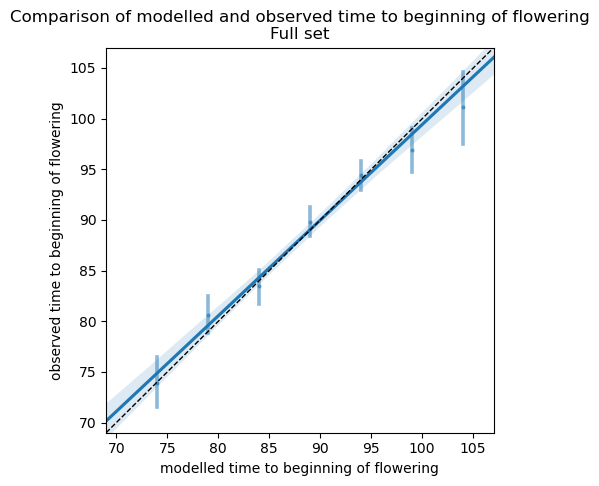

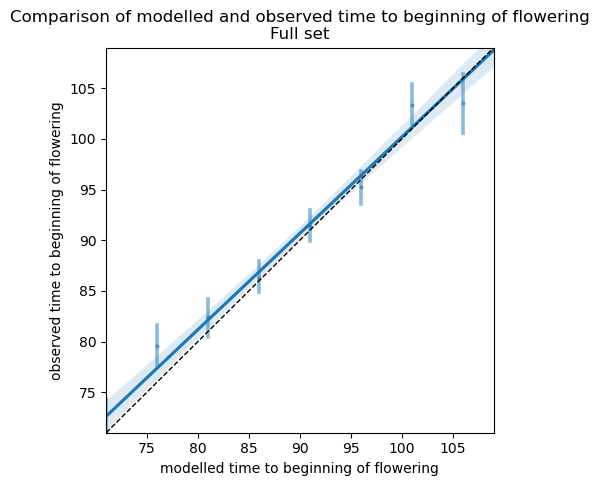

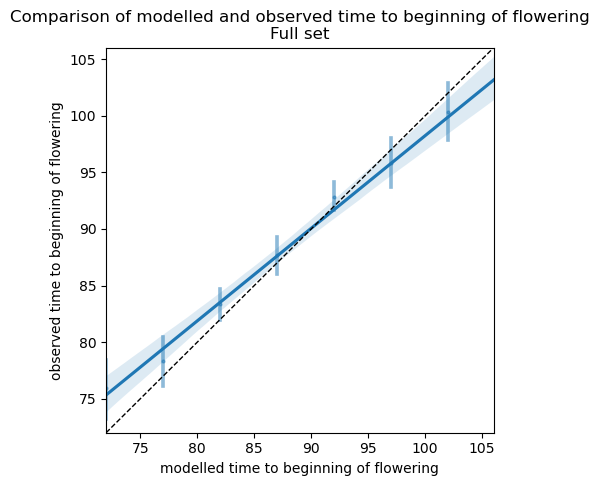

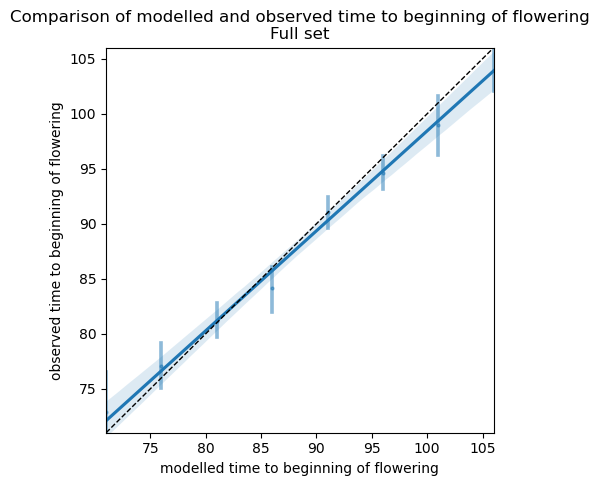

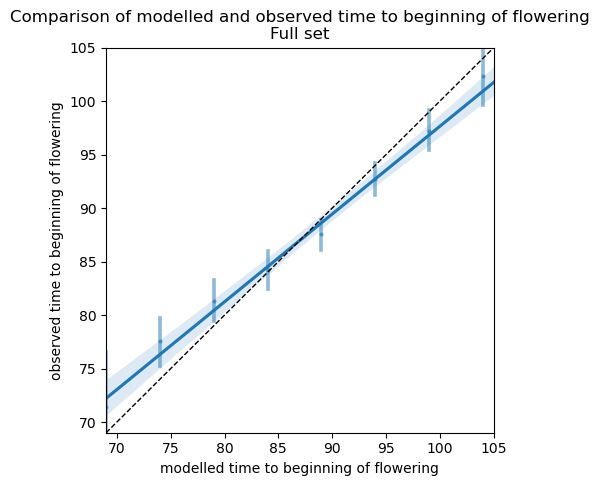

In [17]:
ds_inputs_DE = ds_inputs_DE.rename(columns={'year': 'Referenzjahr'})
R2s, Biases, Variances = KFold_crossval(ds_inputs_DE, 5)

In [21]:
np.mean(R2s)

0.524268667121916

Fold 1
Optimization terminated successfully.
         Current function value: 9.316652
         Iterations: 94
         Function evaluations: 210
[ 0.5  8.  28.  39. ] [ 0.2974811   7.30570159 25.00004627 39.08272624] [ 0.2025189   0.69429841  2.99995373 -0.08272624]
RMSE at opt on test set:  9.636641783570917
R^2: 0.3328155339805825
Parameters:  ([array([ 0.2974811 ,  7.30570159, 25.00004627, 39.08272624])],        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 9.316651759081692
             x: [ 2.975e-01  7.306e+00  2.500e+01  3.908e+01]
           nit: 94
          nfev: 210
 final_simplex: (array([[ 2.975e-01,  7.306e+00,  2.500e+01,  3.908e+01],
                       [ 2.975e-01,  7.306e+00,  2.500e+01,  3.908e+01],
                       ...,
                       [ 2.975e-01,  7.306e+00,  2.500e+01,  3.908e+01],
                       [ 2.975e-01,  7.306e+00,  2.500e+01,  3.908e+01]]), array([ 9.317e+00,  9.317e+00,  9.31

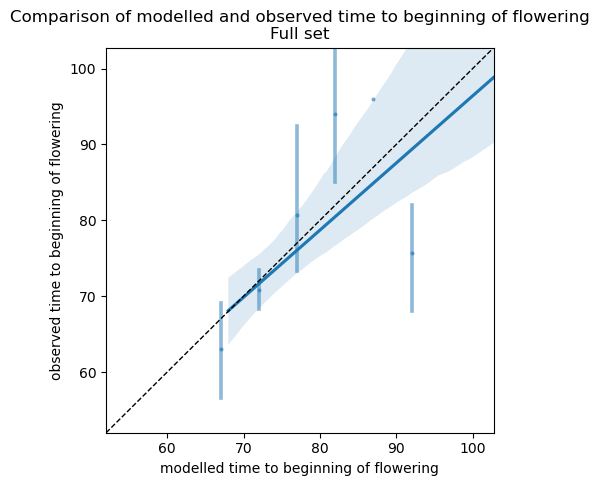

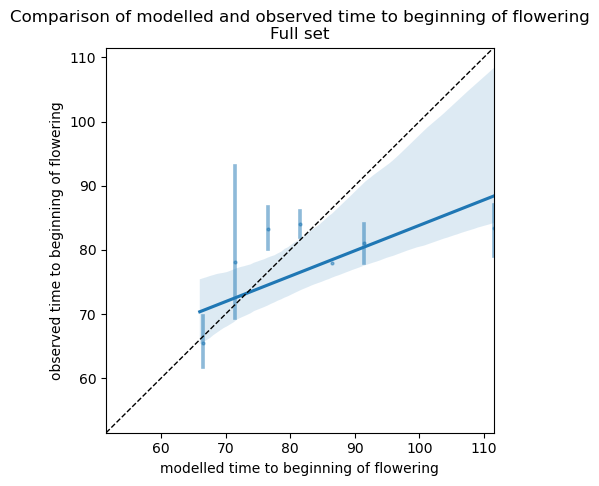

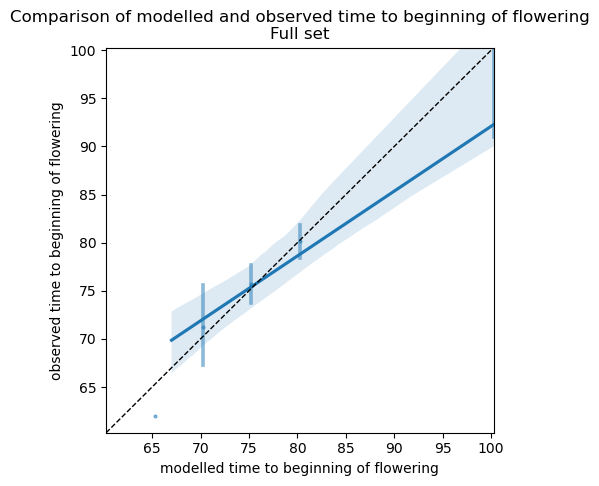

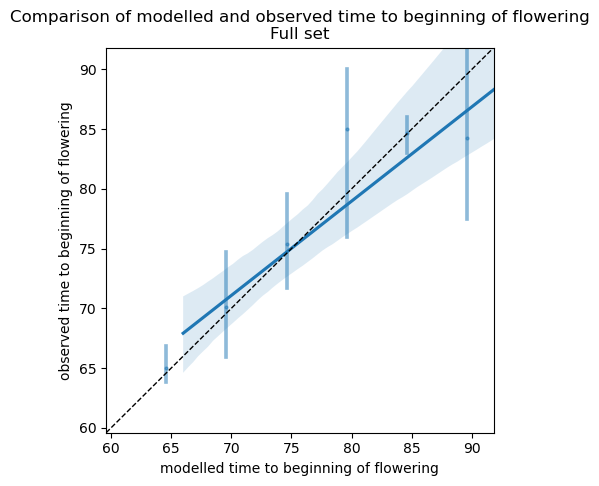

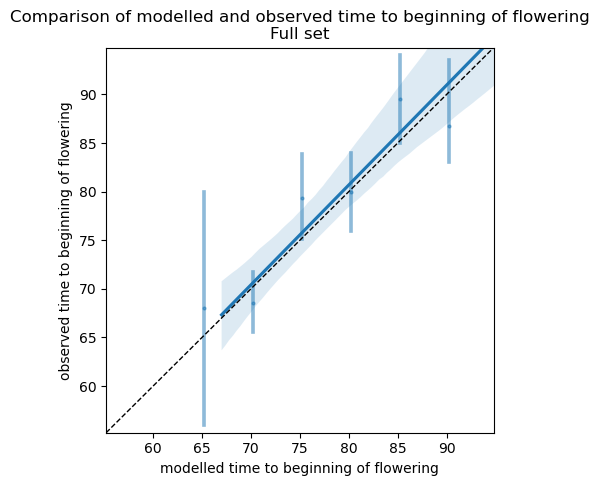

In [18]:
ds_inputs_DE = ds_inputs_DE.rename(columns={'year': 'Referenzjahr'})
R2s_SSA, Biases_SSA, Variances_SSA = KFold_crossval(ds_inputs_SSA, 5)

In [25]:
np.mean(Biases_SSA)

0.462200984853789

In [ ]:
ds_inputs_DE = ds_inputs_DE.rename(columns={'year': 'Referenzjahr'})
R2s, Biases, Variances = KFold_crossval(ds_inputs_SSA, 5, method='trust-constr')

In [55]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
x1s = [np.ones((20))]
x1s = [np.array([0, 0, 0, 0.1, 0.1, 0.2, 0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.3])]
fm_flowering_tc_DE, res = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0 for count in range(20)], upper_bounds = [100 for count in range(20)],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Spline',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 2)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24664\2816556142.py:86: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m',


Optimization terminated successfully.
         Current function value: 11.993501
         Iterations: 1049
         Function evaluations: 1518
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.00000000e+00 6.16952543e-01 0.00000000e+00 4.77769287e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.00212918e-01
 2.80976154e-02 7.94489017e-01 3.51106906e-02 6.29365910e-01
 4.65295861e-02 1.05428433e-01 7.36427971e-02 9.96488558e-01
 3.06015739e+00 4.56658766e+00 3.38213031e-02 2.98297848e-05] [ 1.00000000e+00  3.83047457e-01  1.00000000e+00  9.52223071e-01
  1.00000000e+00  1.00000000e+00  1.00000000e+00  9.97870824e-02
  9.71902385e-01  2.05510983e-01  9.64889309e-01  3.70634090e-01
  9.53470414e-01  8.94571567e-01  9.26357203e-01  3.51144234e-03
 -2.06015739e+00 -3.56658766e+00  9.66178697e-01  9.99970170e-01]
RMSE at opt on test set:  12.032528919691575
R^2: -0.29356293996124916


In [148]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
x1s = [np.ones((20))*0.3]
x1s = [x]
#x1s = [np.arra([0.58303832 0.60021864 0.62112309 0.66657544 0.60308471 0.97653708, 0.52677426 0.54452755 0.56334521 0.46919742])]
#x1s = [np.array([0, 0, 0, 0.1, 0.1, 0.2, 0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.3])]
fm_flowering_tc_DE, res = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0 for count in range(20)], upper_bounds = [100 for count in range(20)],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Spline',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [100], growing_period_length=300,
                     test_size = 0.2, maxiter = 4, random_state = 1)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  41   |   0   | +1.0178e+01 | 5.00e-01 | 4.78e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  82   |   1   | +1.2566e+01 | 3.50e+00 | 2.37e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  123  |   5   | +1.1023e+01 | 2.14e+01 | 1.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|   4   |  205  |  11   | +1.1023e+01 | 2.14e+00 | 1.14e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |

The maximum number of function evaluations is exceeded.
Number of iterations: 4, function evaluations: 205, CG iterations: 11, optimality: 1.14e+01, constraint violation: 0.00e+00, execution time: 5.5e+02 s.
[0.15798619 0.15823926 0.17217433 0.22564493 0.23050108 0.37851778
 0.5118658  0.54246262 0.59964448 0.59681543 0.57583808 0.61641514
 0.57285107 0.54297576 0.52831566 0.51917606 0.5154848  0.51536491
 0.4036713  0.28321193] [0.15910225 0.15935531 0.17328953 0.22675691 0.2350329  0.47261375
 0.52249516 0.55262779 0.60894212 0.60750053 0.49359567 0.61750353
 0.57394209 0.54406859 0.52940937 0.52027032 0.51657928 0.51645941
 0.40477253 0.28432044] [-0.00111606 -0.00111605 -0.00111521 -0.00111198 -0.00453183 -0.09409598
 -0.01062936 -0.01016517 -0.00929765 -0.0106851   0.08224242 -0.00108839
 -0.00109102 -0.00109283 -0.00109371 -0.00109426 -0.00109448 -0.00109449
 -0.00110123 -0.

In [122]:
x = fm_flowering_tc_DE[0]
#x = x1s[0]
def B_0(u):
    return 0.1*((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)
def response(meantemp):
    resp = 0
    for i, coeff in enumerate(x):
        resp += coeff*B_0(0.25*(meantemp - i*2))
    return np.maximum(resp, 0)
def deriv(meantemp):
    return [B_0(0.25*(meantemp - i*2)) for i in range(len(x))]

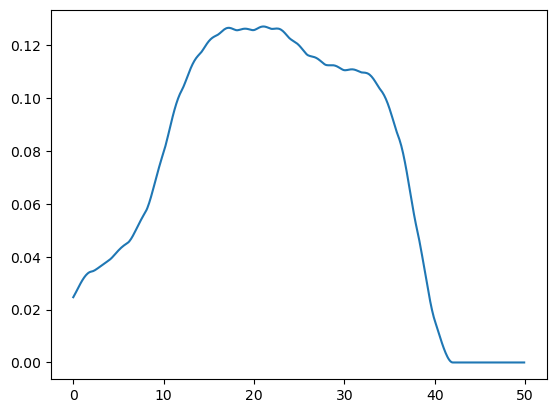

In [123]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 50, 0.1), response(np.arange(0, 50, 0.1)))

In [ ]:
ds

In [95]:
run_GDD_and_get_RMSE_derivs(x1s[0], ds_inputs_DE, 'temperature', response_type='Spline')

[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]

(0.0, 1.0)

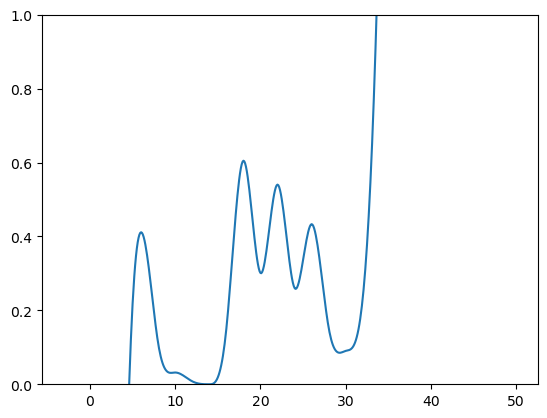

In [59]:
spl = scipy.interpolate.BSpline(np.arange(0, 40, 2), fm_flowering_tc_DE[0], 3)
fig, ax = plt.subplots()
ax.plot(np.arange(-3, 50, 0.1), spl(np.arange(-3, 50, 0.1)))
ax.set_ylim((0, 1))

array([0.00000000e+00, 6.16952543e-01, 0.00000000e+00, 4.77769287e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.00212918e-01,
       2.80976154e-02, 7.94489017e-01, 3.51106906e-02, 6.29365910e-01,
       4.65295861e-02, 1.05428433e-01, 7.36427971e-02, 9.96488558e-01,
       3.06015739e+00, 4.56658766e+00, 3.38213031e-02, 2.98297848e-05])

In [215]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
fm_flowering_tc_DE, res = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 2)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   9   |   0   | +1.0502e+01 | 1.00e+00 | 3.49e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  18   |   1   | +1.4578e+02 | 2.00e+00 | 2.20e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  27   |   5   | +1.0607e+01 | 2.00e+00 | 1.08e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |  36   |   9   | +1.0066e+01 | 2.00e+00 | 7.38e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   5   |  45   |  13   | +9.5025e+00 | 2.00e+00 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   6   |  54   |  16   | +9.5025e+00 | 2.00e-01 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|   7   |  72   |  19   | +9.5025e+00 | 2.00e-02 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |  81   |  22   | +9.5025e+00 | 2.00e-03 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   9   |  90   |  24   | +9.5025e+00 | 6.18e-04 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  10   |  108  |  26   | +9.5025e+00 | 3.09e-04 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  11   |  117  |  27   | +9.5025e+00 | 1.18e-04 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  12   |  126  |  29   | +9.5025e+00 | 5.91e-05 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  13   |  135  |  31   | +9.5025e+00 | 1.62e-05 | 2.80e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  14   |  144  |  33   | +9.5021e+00 | 1.13e-04 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  15   |  162  |  34   | +9.5021e+00 | 5.67e-05 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  16   |  171  |  35   | +9.5021e+00 | 2.66e-05 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  17   |  189  |  36   | +9.5021e+00 | 5.29e-06 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  18   |  207  |  37   | +9.5021e+00 | 6.43e-07 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  19   |  225  |  38   | +9.5021e+00 | 6.43e-08 | 2.52e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |


KeyboardInterrupt: 

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


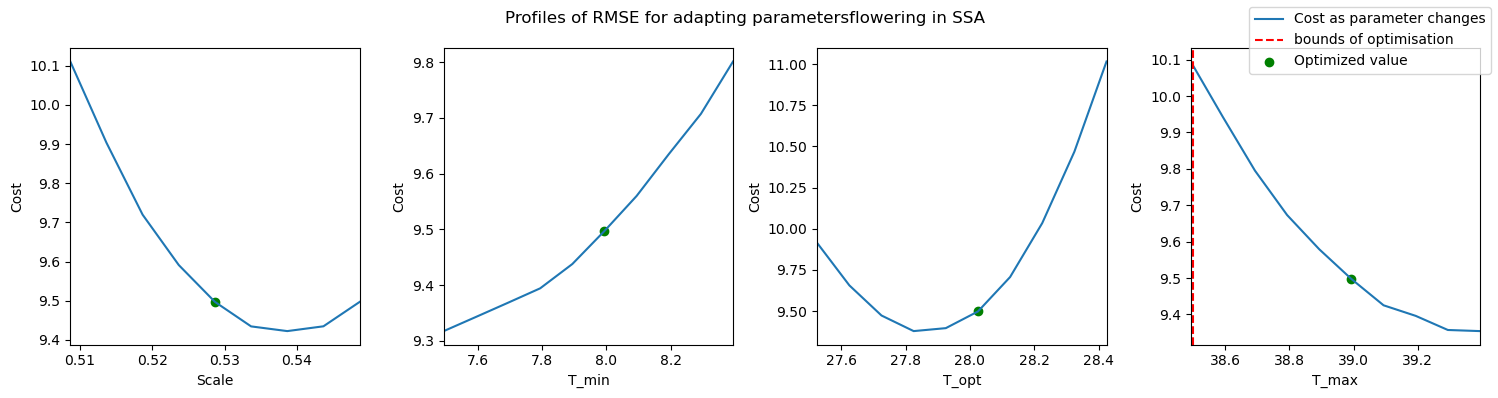

In [211]:
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_tc_DE[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5, 0.1, 0.5], ub = [5, 11, 31, 40, 5, 10], 
                         response_type = 'Convolved', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in SSA')

In [24]:
x1s = [np.array([0.5, 8, 28, 39])]#])]#, 2, 3])]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
fm_flowering_all_DE = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 25, 38], upper_bounds = [5, 11, 30, 40],#38.5, 0.1, 0.5], 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_22984\2333440479.py:86: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m',


Optimization terminated successfully.
         Current function value: 8.247537
         Iterations: 111
         Function evaluations: 208
[ 0.5  8.  28.  39. ] [ 0.38606981  7.08549071 25.01980133 38.93036152] [0.11393019 0.91450929 2.98019867 0.06963848]
RMSE at opt on test set:  8.255753760357793
R^2: 0.42139988467850775


In [39]:
ds_inputs_DE['observed time to beginning of flowering'].max()#['temperature at day 2']

Timedelta('0 days 00:00:00.000000142')

In [31]:
ds_inputs_DE

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Referenzjahr,Stations_id,Day of start,NDVI interpolated at day 0,NDVI interpolated at day 4,NDVI interpolated at day 8,NDVI interpolated at day 12,...,photoperiod at day 240,photoperiod at day 241,photoperiod at day 242,photoperiod at day 243,photoperiod at day 244,photoperiod at day 245,photoperiod at day 246,photoperiod at day 247,photoperiod at day 248,photoperiod at day 249


In [187]:
fm_flowering_all_DE

([array([ 0.21199191,  7.00028345, 31.        , 39.99157465])],
        message: Optimization terminated successfully.
        success: True
         status: 0
            fun: 10.42325905025751
              x: [ 2.120e-01  7.000e+00  3.100e+01  3.999e+01]
            nit: 162
           nfev: 301
  final_simplex: (array([[ 2.120e-01,  7.000e+00,  3.100e+01,  3.999e+01],
                        [ 2.120e-01,  7.000e+00,  3.100e+01,  3.999e+01],
                        ...,
                        [ 2.120e-01,  7.000e+00,  3.100e+01,  3.999e+01],
                        [ 2.120e-01,  7.000e+00,  3.100e+01,  3.999e+01]]), array([ 1.042e+01,  1.042e+01,  1.042e+01,  1.042e+01,
                         1.042e+01])))

In [227]:
x1s = [np.array([0.5, 8, 28, 39, 2, 3])]#])]#, 2, 3])]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
fm_flowering_all_DE = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5, 0.1, 0.5], upper_bounds = [5, 11, 31, 40, 5, 10],#, 0.1, 0.5], 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)

Optimization terminated successfully.
         Current function value: 8.523301
         Iterations: 128
         Function evaluations: 254
[ 0.5  8.  28.  39.   2.   3. ] [ 0.36327417  7.30339085 25.         39.10537745  2.28511994  3.53223723] [ 0.13672583  0.69660915  3.         -0.10537745 -0.28511994 -0.53223723]
RMSE at opt on test set:  8.672576443417832
R^2: 0.342555551931912


In [237]:
ds_inputs_DE['temperature at day 100'].loc[ds_inputs_DE['temperature at day 101'] > 29]

727     27.217819
772     27.218968
786     27.230669
1517    25.101677
1612    25.026906
1664    29.172390
1692    28.756474
1716    25.008982
1749    28.187103
1823    25.699261
1840    25.417485
2053    27.112424
2160    27.245300
2429    28.016266
2450    28.669037
2467    28.450459
2483    29.334440
2582    28.928718
2591    29.341491
2603    29.210087
2626    28.371451
2642    28.510575
2981    28.993500
3019    28.901581
3053    28.093795
3073    27.085524
3120    27.746029
3163    27.821045
3173    27.511913
3194    27.247478
3199    27.266586
3346    27.301348
3359    29.367708
3374    28.878549
3398    28.111112
3433    28.890415
3450    29.524300
3473    27.922991
3487    28.041587
3909    29.983504
4039    28.907181
4079    30.312781
6960    25.872260
7982    27.648297
8897    27.718921
9019    27.308768
9053    28.008745
9145    27.780496
9163    29.242437
9170    30.850643
9384    25.797545
9389    31.868310
9394    25.480603
9455    26.918527
Name: temperature at day 100

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


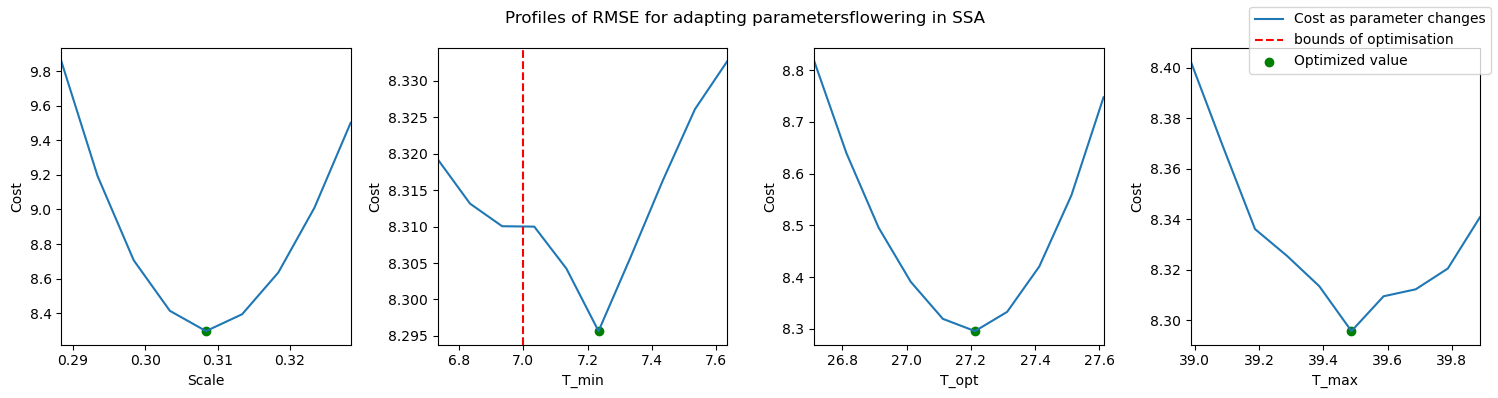

In [250]:
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5, 0.1, 0.5], ub = [5, 11, 31, 40, 5, 10], 
                         response_type = 'Convolved', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in SSA')

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


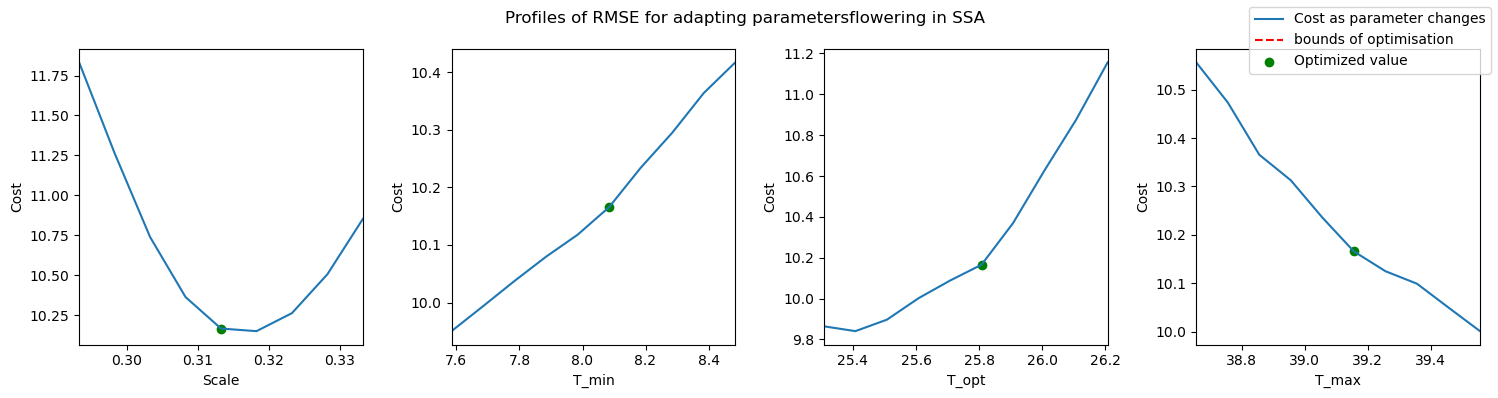

In [27]:
train_a, test_a = train_test_split(ds_inputs_SSA, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_all_SSA[0][0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in SSA')

In [23]:
x1s = [np.array([0.5, 8, 28, 39])]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
fm_flowering_all_DE = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_22984\2333440479.py:86: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  res = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE(x, train, 't2m',


Optimization terminated successfully.
         Current function value: 8.319230
         Iterations: 109
         Function evaluations: 213
[ 0.5  8.  28.  39. ] [ 0.37058664  7.12932774 25.00236693 39.02721538] [ 0.12941336  0.87067226  2.99763307 -0.02721538]
RMSE at opt on test set:  8.311148268664432
R^2: 0.41360924587548575


In [12]:
ds_inputs_DE

,Unnamed: 0,Stations_id,Referenzjahr,Planting date,temperature at day 0,temperature at day 1,temperature at day 2,temperature at day 3,temperature at day 4,temperature at day 5,...,t2m at day 302,t2m at day 303,t2m at day 304,t2m at day 305,t2m at day 306,t2m at day 307,t2m at day 308,t2m at day 309,observed time to beginning of flowering,observed time to beginning of tilling sowing drilling


In [ ]:
ds_inputs_DE.iloc

In [33]:
ds_inputs_DE.dropna()['temperature at day 100']

2879     15.539086
2880     20.641624
2881     19.418412
2882     22.918135
2883     17.436548
           ...    
11009    20.557140
11010    23.819839
11011    26.179277
11120    19.597371
11121    22.995094
Name: temperature at day 100, Length: 1721, dtype: float64

In [20]:
ds_inputs_DE['observed time to beginning of flowering'].min()

Timedelta('10 days 00:00:00')

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

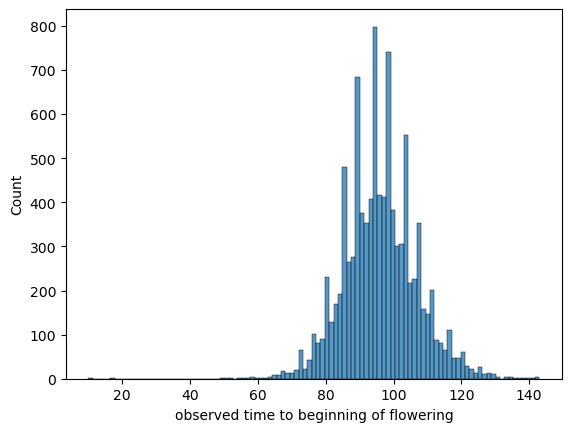

In [22]:
sns.histplot(ds_inputs_DE['observed time to beginning of flowering'].dt.days)

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


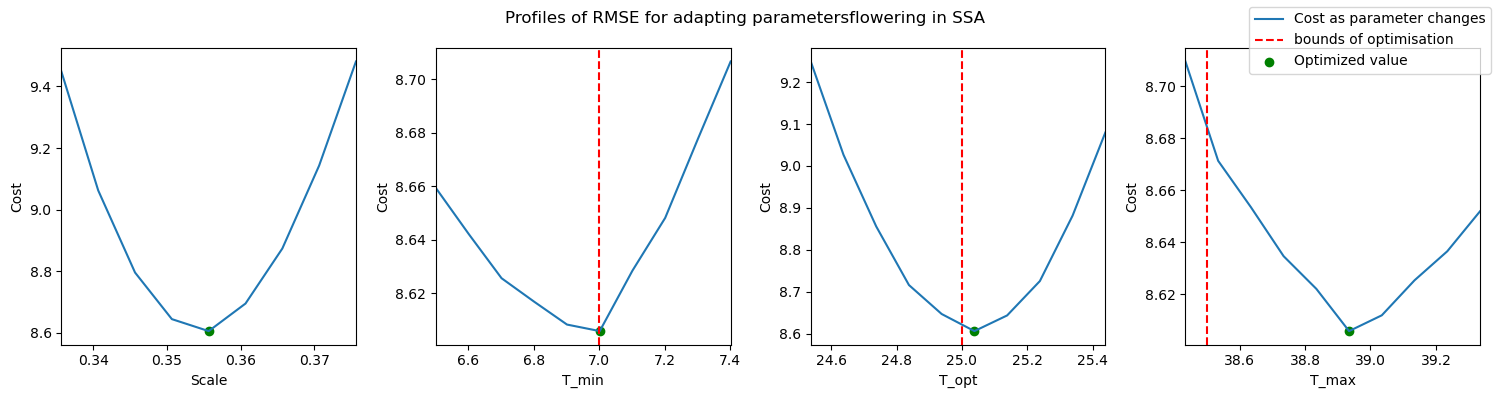

In [26]:
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in SSA')

In [38]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]
fm_flowering_tc, res = local_opt(x1s, ds_inputs_SSA, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 100, random_state = 2)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +2.2242e+01 | 1.00e+00 | 4.25e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +7.0953e+01 | 7.00e+00 | 1.09e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |   5   | +1.9596e+01 | 7.00e+00 | 1.51e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |   4   |   9   | +1.7478e+01 | 7.00e+00 | 1.21e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   5   |   6   |  13   | +1.7478e+01 | 7.00e-01 | 1.21e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   6   |   8   |  17   | +1.7478e+01 | 1.37e-01 | 1.21e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   7   |   9   |  20   | +1.5518e+01 | 9.58e-01 | 6.21e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   8   |  10   |  23   | +1.3183e+01 | 5.65e+

c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  58   |  79   |  92   | +1.0297e+01 | 4.30e-07 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  59   |  81   |  93   | +1.0297e+01 | 2.15e-07 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  60   |  83   |  94   | +1.0297e+01 | 1.07e-07 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  61   |  85   |  95   | +1.0297e+01 | 5.37e-08 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  62   |  87   |  96   | +1.0297e+01 | 2.69e-08 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  63   |  89   |  97   | +1.0297e+01 | 1.34e-08 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  64   |  91   |  98   | +1.0297e+01 | 6.72e-09 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  65   |  93   |  99   | +1.0297e+01 | 3.36e-09 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  66   |  95   |  100  | +1.0297e+01 | 1.68e-09 | 6.73e-01 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  67   |  97   |  101  | +1.0297e+01 | 8.39e-

In [ ]:
x_opt = one_by_one_optimisation(fm_flowering_tc[0], train_a, #np.array(x_opt)
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300,
                         thresholds = [20])

Plotting Scale
Plotting T_min
Plotting T_opt


KeyboardInterrupt: 

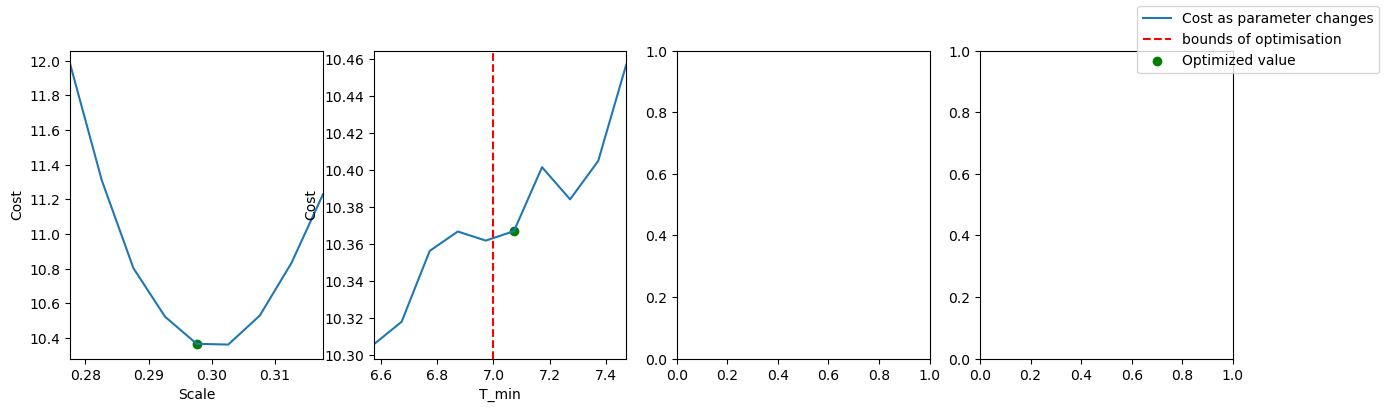

In [39]:
train_a, test_a = train_test_split(ds, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_tc[0], train_a, #fm2s[0], ds2, #fm2s[0] x_opt np.array([x_opt[0], 7, 25, 40])
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20])

In [212]:
start_year = 2000
end_year = 2023
step = 2
response_type = 'Wang'
phase_list = ['yellow ripeness']
method = 'trust-constr', 
modified_cost = False, 
thresholds = [100], 
growing_period_length = 185,
maxiter = 50
x1s = [np.array([0.3, 6, 29.5, 42])]
param_list = []
for year in range(start_year, end_year, step):
    ds2_warm_period = ds2_warm.loc[(ds2_warm['Referenzjahr'] >= year)*(ds2_warm['Referenzjahr'] < year + step)]
    fms, res = local_opt(x1s, ds2_warm_period, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300, split = False)
    plot_profiles_at_minimum(fms[0], ds2_warm_period, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])
    param_list.append(fms[0])
    #print(ds2_warm_period)


NameError: name 'ds2_warm' is not defined

In [15]:
x1s = [np.array([0.3, 6, 29.5, 42])]
#x1s = [fms[0]]
fm_all_ripeness, res = local_opt(x1s, ds2, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300)

Optimization terminated successfully.
         Current function value: 14.168034
         Iterations: 130
         Function evaluations: 237
[ 0.3  6.  29.5 42. ] [ 0.24281304  5.00383729 28.15685861 43.96110362] [ 0.05718696  0.99616271  1.34314139 -1.96110362]
RMSE at opt on test set:  19.941897092174766
R^2: -0.029379434800168136


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


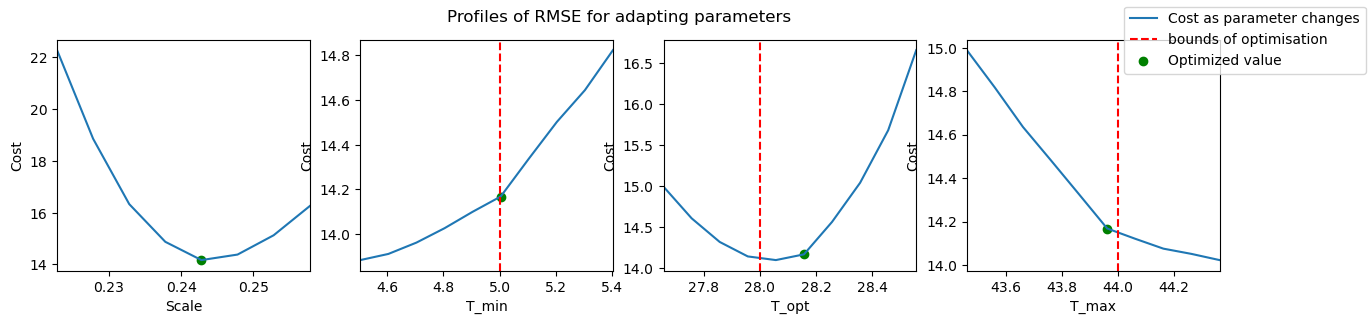

In [21]:
train, test = train_test_split(ds2, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm_all_ripeness[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [16]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.3, 6, 29.5, 42])]
fms, res = local_opt(x1s, ds2_cold, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20])


Optimization terminated successfully.
         Current function value: 13.376611
         Iterations: 107
         Function evaluations: 206
[ 0.3  6.  29.5 42. ] [ 0.25222093  5.01214034 28.02067488 43.695618  ] [ 0.04777907  0.98785966  1.47932512 -1.695618  ]
RMSE at opt on test set:  17.82466439988874
R^2: 0.12521048556632275


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


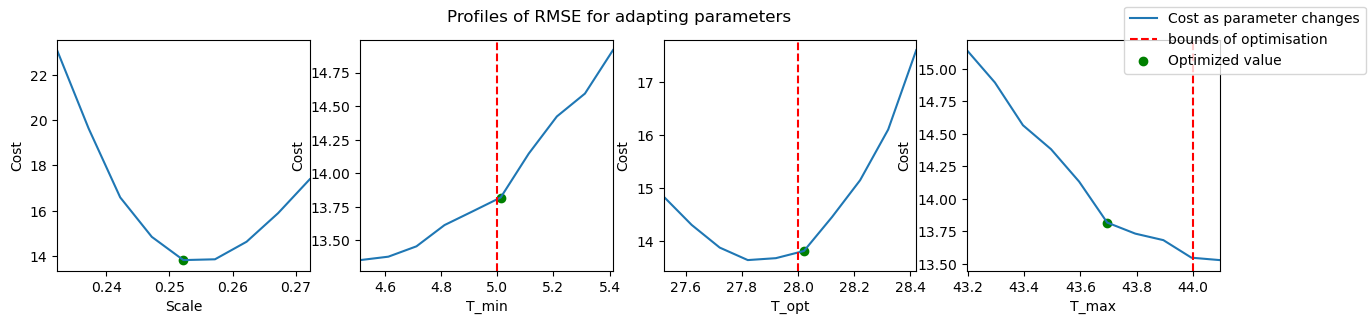

In [17]:
train, test = train_test_split(ds2_cold, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fms[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [30]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.3, 6, 29.5, 42])]
#x1s = [fms[0]]
fm2s, res = local_opt(x1s, ds2_warm, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300)

NameError: name 'ds2_warm' is not defined

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


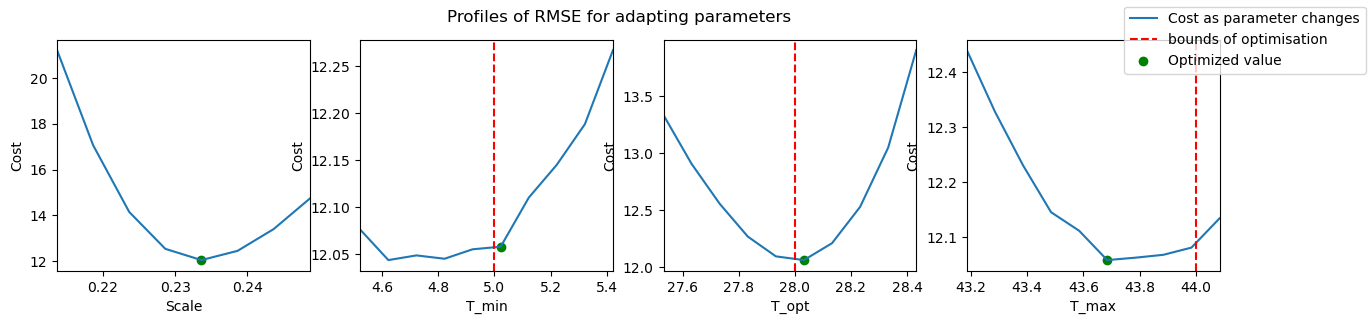

In [19]:
train, test = train_test_split(ds2_warm, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm2s[0], train, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 5, 28, 38], ub = [5, 7.5, 33, 44], 
                         response_type = 'Wang', phase_list = ['yellow ripeness'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])


In [120]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm3s, res = local_opt(x1s, ds_warm, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=200)
train_a, test_a = train_test_split(ds, test_size=0.5, random_state = 1)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +2.0043e+01 | 1.00e+00 | 2.91e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +2.0972e+01 | 7.00e+00 | 4.15e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |   5   | +1.5255e+01 | 7.00e+00 | 1.88e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |   4   |   8   | +1.1401e+01 | 7.00e+00 | 1.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   |   6   |  12   | +1.1401e+01 | 7.00e-01 | 1.56e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   6   |   7   |  15   | +1.1347e+01 | 7.00e-01 | 1.54e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |   8   |  18   | +1.1286e+01 | 7.00e-01 | 1.54e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |   9   |  21   | +9.5472e+00 | 1.40e+

c:\ProgramData\anaconda3\envs\Data_Analysis_Revived\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  41   |  61   |  72   | +9.5413e+00 | 1.76e-02 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  42   |  63   |  74   | +9.5413e+00 | 8.82e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  43   |  64   |  75   | +9.5413e+00 | 4.41e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  44   |  65   |  76   | +9.5413e+00 | 2.20e-03 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  45   |  67   |  77   | +9.5413e+00 | 9.35e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  46   |  68   |  78   | +9.5413e+00 | 4.67e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  47   |  70   |  79   | +9.5413e+00 | 1.99e-04 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  48   |  72   |  80   | +9.5413e+00 | 4.29e-05 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  49   |  74   |  81   | +9.5413e+00 | 7.43e-06 | 2.43e+00 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   2   |
|  50   |  76   |  82   | +9.5413e+00 | 3.72e-

In [ ]:
plot_profiles_at_minimum(fm3s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [40]:
x1s = [np.array([0.8, 8, 28, 39])]
fm_flowering_all_DE = local_opt(x1s, ds_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 9.838051
         Iterations: 138
         Function evaluations: 274
[ 0.8  8.  28.  39. ] [ 0.60195695  8.2342903  28.64357561 39.46867037] [ 0.19804305 -0.2342903  -0.64357561 -0.46867037]
RMSE at opt on test set:  10.001840890158821
R^2: 0.0766758382928796


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


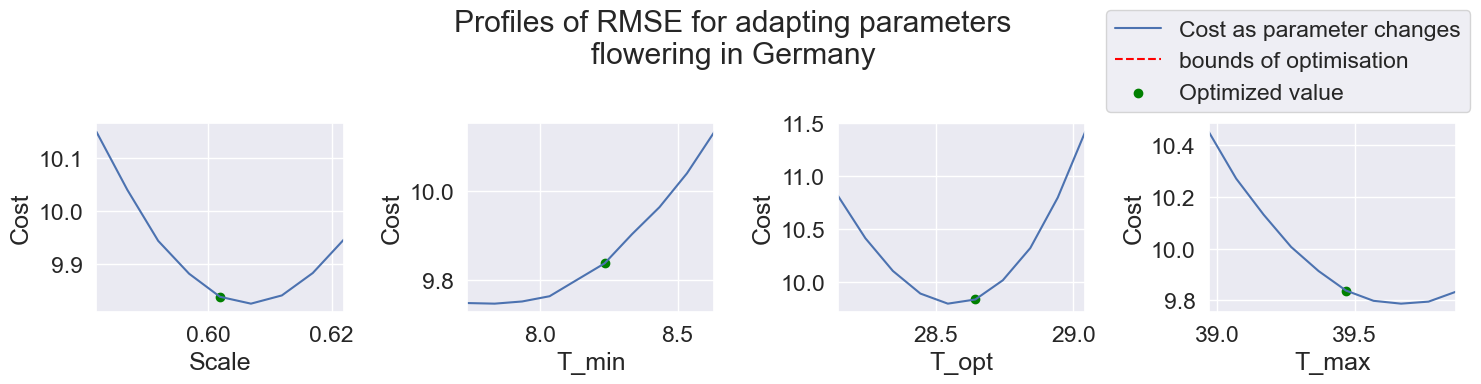

In [42]:
train_a, test_a = train_test_split(ds_DE, test_size=0.5, random_state = 1)
sns.set(font_scale=1.5) #[fm_flowering_all_DE[0][0][0], 7, 25, 40]
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], train_a, #fm2s[0], ds2, #fm2s[0] #fm_flowering_all[0][0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20], title = '\nflowering in Germany')

In [25]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm5s, res = local_opt(x1s, ds_warm, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 8.309354
         Iterations: 110
         Function evaluations: 237
[ 0.8  8.  28.  39. ] [ 0.38455098  7.85891439 25.01171837 38.67322138] [0.41544902 0.14108561 2.98828163 0.32677862]
RMSE at opt on test set:  8.268961093512054
R^2: 0.3372506254579203


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


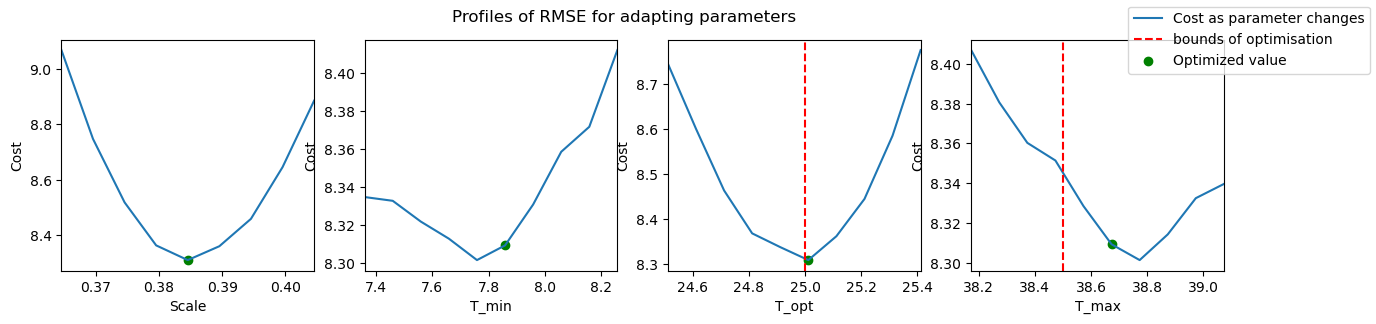

In [26]:
train_a, test_a = train_test_split(ds_warm, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm5s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [29]:
#x1s = [np.array([2.22415, 10, 27, 39.5])]#,
x1s = [np.array([0.8, 8, 28, 39])]
fm6s, res = local_opt(x1s, ds_cold, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 8.683780
         Iterations: 196
         Function evaluations: 353
[ 0.8  8.  28.  39. ] [ 0.37629408  7.08260145 25.02142537 39.63852827] [ 0.42370592  0.91739855  2.97857463 -0.63852827]
RMSE at opt on test set:  8.666066536777695
R^2: 0.35085707964200563


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


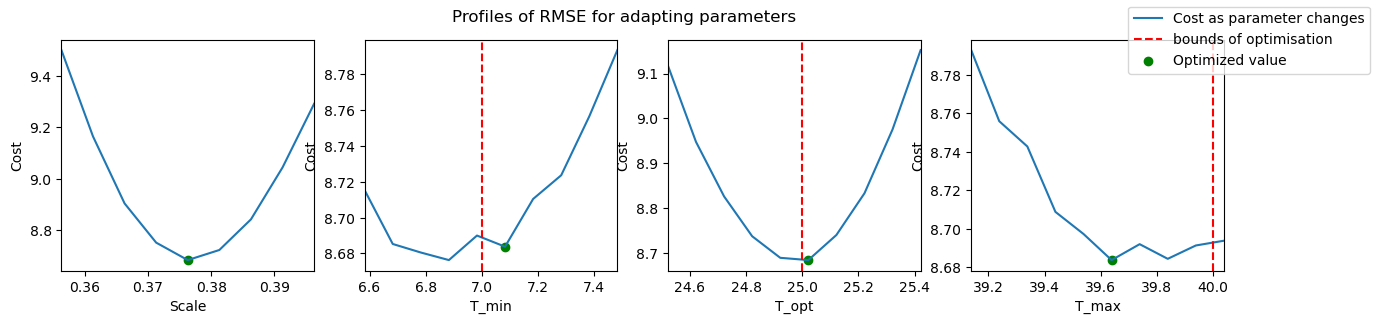

In [30]:
train_a, test_a = train_test_split(ds_cold, test_size=0.5, random_state = 1)
plot_profiles_at_minimum(fm6s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [36]:
parameter_data = np.concatenate([np.array([fm_all_ripeness[0]]), 
                                 np.array([fm2s[0]]), np.array([fms[0]]), 
                                 np.array([fm_flowering_all[0][0]]), 
                                 np.array([fm5s[0]]), 
                                 np.array([fm6s[0]])], axis=0)

In [47]:
column_names = ['Scale (thermal time requirement)', 'T_min', 'T_opt',  'T_max']
row_names = np.array(['Full set, ripeness', 'Warm set, ripeness', 'Cold set, ripeness',
                      'Full set, flowering', 'Warm set, flowering', 'Cold set, flowering'])
R2s = np.array([-0.029379434800168136, 0.33311833790242984, 0.12521048556632275,
                0.3281956184199428, 0.3372506254579203, 0.35085707964200563])
parameters_frame = pd.DataFrame(parameter_data, columns = column_names, index = row_names)
parameters_frame['R2'] = R2s

In [62]:
np.round(parameters_frame, decimals = 2)

,Scale,T_min,T_opt,T_max,R2
"Full set, ripeness",0.24,5.00,28.16,43.96,-0.03
"Warm set, ripeness",0.23,5.02,28.03,43.68,0.33
"Cold set, ripeness",0.25,5.01,28.02,43.70,0.13
"Full set, flowering",0.38,7.01,25.07,38.89,0.33
"Warm set, flowering",0.38,7.86,25.01,38.67,0.34
"Cold set, flowering",0.38,7.08,25.02,39.64,0.35


In [14]:
def one_by_one_optimisation(x0, ds, lb, ub, phase_list = ['yellow ripeness'], thresholds = [10], growing_period_length = 200, response_type = 'Wang', ):
    fixed_params = x0.copy()[1:].tolist()
    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})

    T_min = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, x] + fixed_params[1:], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[1], ub[1]),
                                                method='bounded',
                                                options = {'disp': 3})
                            
    T_opt = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, T_min.x, x] + fixed_params[2:], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[2], ub[2]),
                                                method='bounded',
                                                options = {'disp': 3})
    T_max = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, T_min.x, T_opt.x, x], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[3], ub[3]),
                                                method='bounded',
                                                options = {'disp': 3})

    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x, T_min.x, T_opt.x, T_max.x], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})


    x_opt = [x_0.x, T_min.x, T_opt.x, T_max.x]
    return x_opt

In [20]:
x_opt = one_by_one_optimisation(fm3s[0], train_a,
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200,
                         thresholds = [20])

 
 Func-count     x          f(x)          Procedure
    1        1.91601      46.0385        initial
    2        3.09399      55.7688        golden
    3        1.18798       33.381        golden
    4       0.738031      16.4724        golden
    5       0.459948      17.5153        golden
    6       0.632022      10.8563        parabolic
    7       0.604678      9.86623        parabolic
    8       0.549396      9.82621        golden
    9       0.576194      9.44314        parabolic
   10        0.57635      9.44053        parabolic
   11        0.58717      9.52115        golden
   12       0.580067      9.44998        parabolic
   13       0.577953      9.45067        parabolic
   14       0.576354      9.44093        parabolic
   15       0.576282      9.44159        parabolic
   16       0.576324      9.44061        golden
   17       0.576338      9.44071        parabolic
   18       0.576345       9.4405        golden
   19       0.576342      9.44068        parabolic

Opt

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


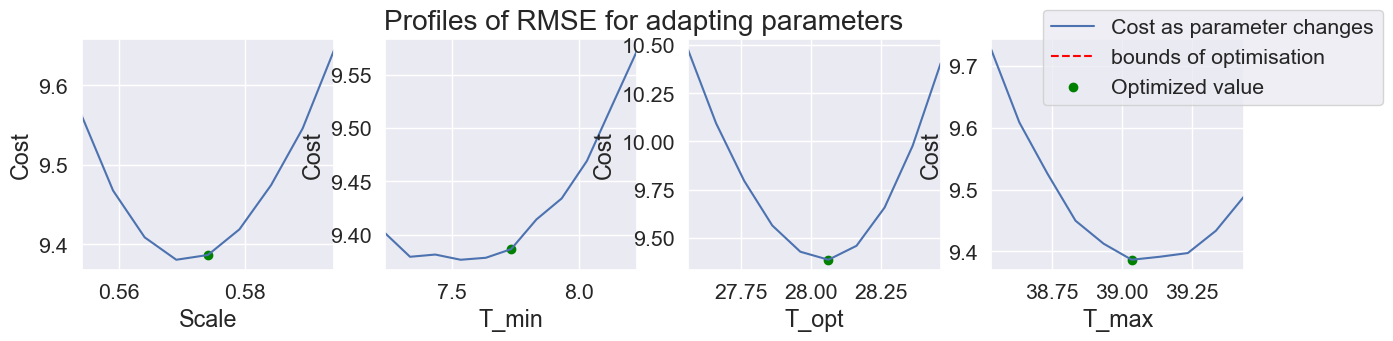

In [23]:
plot_profiles_at_minimum(x_opt, train_a,
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [15]:
def global_search(ds, param_values,
                     N = 200, 
                     interesting_threshold = 16, great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness']):
    np.random.seed(10)
    count_tested = 0
    results_array = pd.DataFrame(columns = ['Tmin', 'Topt', 'Tmax', 'optimised scale', 'RMSE'])
    for Tmin_index, Tmin in enumerate(param_values[0]):
        for Topt_index, Topt in enumerate(param_values[1]):
            for Tmax_index, Tmax in enumerate(param_values[2]):
                x0 = [0.12, Tmin, Topt, Tmax]
                constraint_violation = x0[1] < x0[0] or x0[2] < x0[1]
                if constraint_violation:
                    print(x0, 'goes against constraints')
                    continue
                fixed_params = [Tmin, Topt, Tmax]
                x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type=response_type, phase_list = phase_list),
                                                    bounds = (0.05, 1.5),
                                                    method='bounded',
                                                    options = {'disp': 2})
                x1 = np.array([x_0.x] + fixed_params)
                opt_value = run_GDD_and_get_RMSE(x1, ds, 't2m', response_type=response_type,  phase_list = phase_list)
                new_row = pd.DataFrame({'Tmin':[Tmin], 'Topt':[Topt], 'Tmax':[Tmax], 'optimised scale':[x1[0]], 'RMSE':[opt_value]})
                count_tested += 1
                print(f'{count_tested} samples considered')
                results_array = pd.concat([results_array, new_row])
                print(results_array)
    return results_array

In [16]:
def run_GDD_and_plot(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid', 
                             phase_list = ['beginning of flowering'], exclude_unfinished = False,
                             growing_period_length = 300, thresholds = [100], 
                             title_extra='', method='scatter'):
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], 0.2, 3)#x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])

    ## Initiate development time storage object - a list with a value for all the stations, that will change over time and be stored in a list.
    t_dev = np.zeros(len(ds)) #Continuous development time. When this passes through some thresholds then have change in phase.
    dev_time_series = [t_dev.copy()]
    ## Make sure driver dataset uses station id to index this dimension
    
    #Run model
    for day in range(growing_period_length):
        # Pull values for temperature out of data frame
        driver_values = ds[f'temperature at day {day}']
        # Calculate the response for each of these temperatures and add it to the total accumulated temperature
        t_dev += response(driver_values)#, t_dev)
        #Store the accumulated temperature in an array
        dev_time_series.append(t_dev.copy())

    # Add the year and station codes for indexing later and to check that extracting values didn't mix up indexes
    dev_time_series.append(ds['Referenzjahr'].values)
    dev_time_series.append(ds['Stations_id'].values)
    #print([p.shape for p in dev_time_series])
    model_dev_time_series = np.array(dev_time_series)
    #driver_array['Development Time'] = (('days from emergence', 'Emergence observation'), model_dev_time_series)
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['Referenzjahr'], ['Stations_id']])
    phase_dates_array = np.zeros((len(thresholds), model_dev_time_series.shape[1]))
    for obs_index in range(model_dev_time_series.shape[1]):
        phase_dates_array[:, obs_index] = np.digitize(thresholds, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['Referenzjahr', 'Stations_id']).dropna()
    fig, axs = plt.subplots(1, len(phase_list), figsize = (len(phase_list)*5, 5))
    for phase_index, phase in enumerate(phase_list):
        number_unfinished = (comparison_array[f'modelled time to {phase}'] >= growing_period_length).sum()
        number_total = len(comparison_array)
        print(f'{number_unfinished} stations out of {number_total} did not reach the end of phase \'{phase}\'')
        if exclude_unfinished:
            comparison_array = comparison_array[comparison_array[f'modelled time to {phase}'] < growing_period_length].dropna()
        comparison_array[f'observed time to {phase}'] = comparison_array[f'observed time to {phase}'].dt.days
        if len(phase_list) == 1:
            ax = axs
        else:
            ax = axs[phase_index]
        if method == 'regression':
            #x_estimator=np.mean,
            #minval = min(comparison_array[f'observed time to {phase}'].min(), comparison_array[f'modelled time to {phase}'].min()) - 1
            #maxval = max(comparison_array[f'observed time to {phase}'].max(), comparison_array[f'modelled time to {phase}'].max()) + 1
            minval = min(comparison_array[f'observed time to {phase}'].quantile(0.05), comparison_array[f'modelled time to {phase}'].quantile(0.05)) - 1
            maxval = max(comparison_array[f'observed time to {phase}'].quantile(0.95), comparison_array[f'modelled time to {phase}'].quantile(0.95)) + 1
            sns.regplot(x=f'modelled time to {phase}', y=f'observed time to {phase}', data=comparison_array, ax=axs,
                        scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
            axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
            axs.set_xlim(minval, maxval)
            axs.set_ylim(minval, maxval)
            axs.set_title(f'Comparison of modelled and observed time to {phase}\n{title_extra}')
        elif method == 'histogram':
            sns.histplot(x=f'modelled time to {phase}', data = comparison_array, ax=ax, label = 'fitted',
                        stat = 'density')
            sns.histplot(x=f'observed time to {phase}', data = comparison_array, ax=ax, label= 'observed',
                        stat = 'density')
            ax.set_xlabel('Days to anthesis')
            #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
            fig.legend(bbox_to_anchor = (1.2, 0.9))
            rsquared = r2_score(comparison_array[f'observed time to {phase}'], comparison_array[f'modelled time to {phase}'])
            print(f'R^2 value for model: {rsquared}')
            bias = comparison_array[f'observed time to {phase}'].mean() - comparison_array[f'modelled time to {phase}'].mean()
            variance_modelled = comparison_array[f'modelled time to {phase}'].var()
            print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

    rsquared = r2_score(comparison_array[f'observed time to {phase}'], comparison_array[f'modelled time to {phase}'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_array[f'observed time to {phase}'].mean() - comparison_array[f'modelled time to {phase}'].mean()
    variance_modelled = comparison_array[f'modelled time to {phase}'].var()
    print(f'Bias: {bias**2} (sign {np.sign(bias)})\nVariance of modelled values: {variance_modelled}')
    return comparison_array

8 stations out of 1404 did not reach the end of phase 'yellow ripeness'
R^2 value for model: 0.07936085266295356
Bias: 8.17780750562087 (sign 1.0)
Variance of modelled values: 200.14510369517527


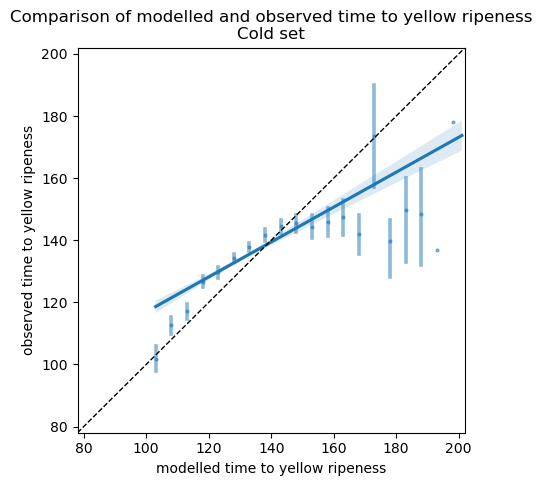

In [54]:
train, test = train_test_split(ds2_cold, test_size=0.5, random_state = 1)
ca_ripeness_cold = run_GDD_and_scatter_plot(fms[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Cold set')

0 stations out of 2540 did not reach the end of phase 'yellow ripeness'
R^2 value for model: 0.33285568265938137
Bias: 0.4453197656395564 (sign 1.0)
Variance of modelled values: 121.66391008922236


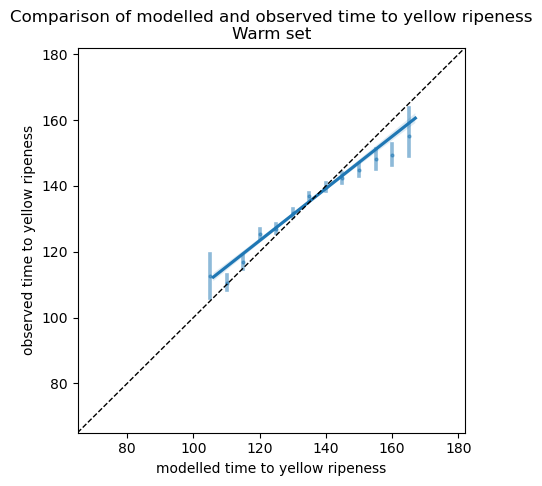

In [55]:
train, test = train_test_split(ds2_warm, test_size=0.5, random_state = 1)
ca_ripeness = run_GDD_and_scatter_plot(fm2s[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Warm set')

39 stations out of 3944 did not reach the end of phase 'yellow ripeness'
R^2 value for model: -0.029640499835624334
Bias: 2.9421295320080136 (sign 1.0)
Variance of modelled values: 221.68053374943779


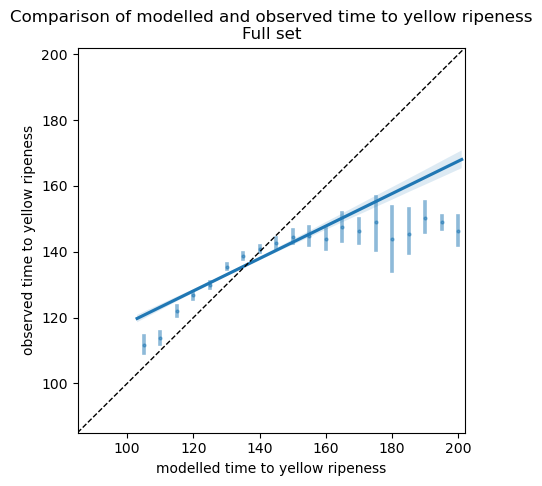

In [56]:
train, test = train_test_split(ds2, test_size=0.5, random_state = 1)
ca_ripeness = run_GDD_and_scatter_plot(fm_all_ripeness[0], test, 't2m', response_type='Wang', phase_list = ['yellow ripeness'], exclude_unfinished=False, growing_period_length=200, thresholds = [20],
                                            title_extra='Full set')

0 stations out of 216 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.39056466555111746
Bias: 0.2408264746227637 (sign 1.0)
Variance of modelled values: 94.67596899224806


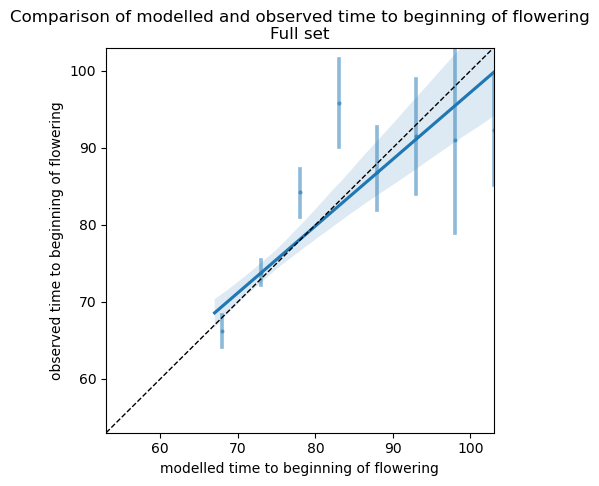

In [12]:
train_a, test_a = train_test_split(ds, test_size=0.2, random_state = 1)
ca_flowering = run_GDD_and_plot(fm_flowering_tc[0], train_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')#np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

In [58]:
fm_flowering_all_DE[0][0]

array([ 0.48663229,  7.02124259, 27.88597449, 39.99906687])

0 stations out of 51 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.12740820402519593
Bias: 0.11111111111110795 (sign 1.0)
Variance of modelled values: 32.483137254901955


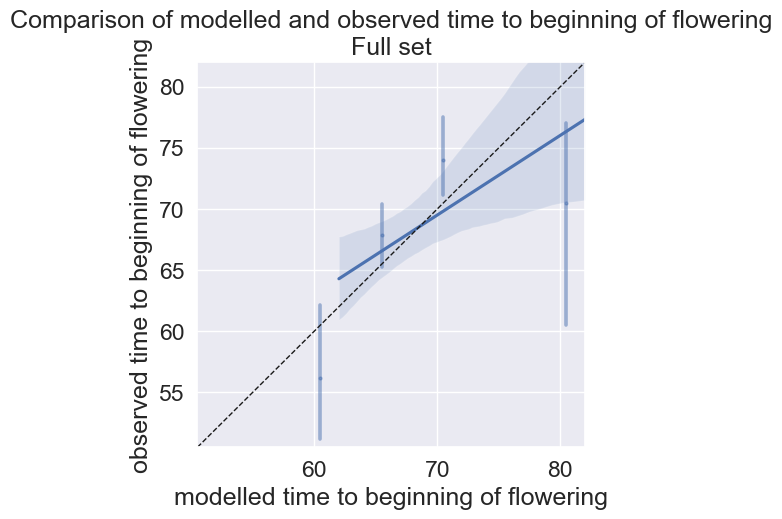

In [61]:
train_a, test_a = train_test_split(ds, test_size=0.2, random_state = 1)
ca_flowering = run_GDD_and_plot([fm_flowering_tc[0][0], 7, 25, 40], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')#np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

In [39]:
fm_flowering_tc[0]

array([ 0.32491715,  7.14326516, 25.08753995, 39.83443631])

In [29]:
fm_flowering_all[0][0]

array([ 0.18833668,  7.5060529 , 25.0202482 , 39.96409198])

In [206]:
np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

array([ 0.5       ,  9.69138985, 31.        , 38.9057878 ])

0 stations out of 3484 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3370603442708511
Bias: 0.01272415081705384 (sign 1.0)
Variance of modelled values: 52.864617728293425


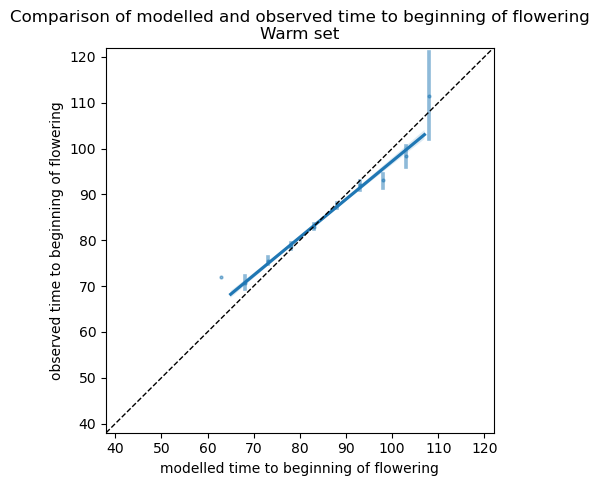

In [60]:
train_a, test_a = train_test_split(ds_warm, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_scatter_plot(fm5s[0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, 
                                        thresholds = [20], title_extra='Warm set')

0 stations out of 2115 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3505500110893277
Bias: 0.015817670696199153 (sign -1.0)
Variance of modelled values: 52.15977374745873


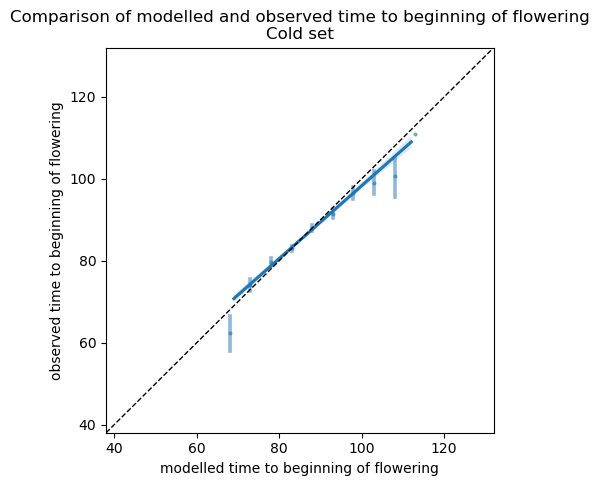

In [61]:
train_a, test_a = train_test_split(ds_cold, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_scatter_plot(fm6s[0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, 
                                        thresholds = [20], title_extra='Cold set')

0 stations out of 5599 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.16468430613847995
Bias: 0.3049706430558551
Variance of modelled values: 98.71395226307803


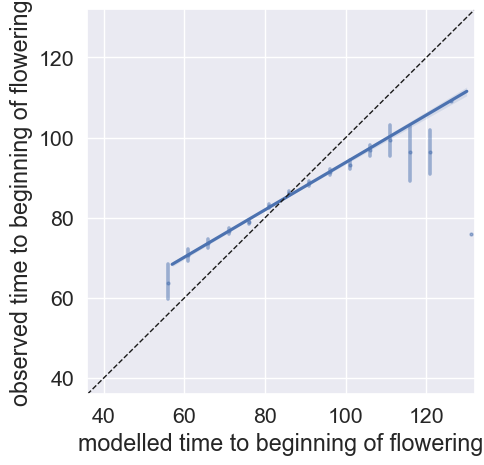

In [41]:
ca_flowering_2nd_min = run_GDD_and_scatter_plot(x_opt, test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200, thresholds = [20])

In [23]:
ca_not_matured = ca_ripeness.where(ca_ripeness['modelled time to yellow ripeness'] ==201).dropna()
ca_not_matured = get_station_locations(ca_not_matured, Maize_set.station_data)
ca_not_matured[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/canm_latlon2.csv')
ca_not_matured['Referenzjahr'].unique()

array([2002., 2004., 2010., 2008., 2015., 2007., 2012.])

In [127]:
ca_late_matured = ca_ripeness.where(ca_ripeness['modelled time to yellow ripeness'] > 160).dropna()
ca_late_matured = get_station_locations(ca_late_matured, Maize_set.station_data)
ca_late_matured[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/calm_latlon3.csv')
ca_late_matured['Referenzjahr'].unique()

array([2015., 2010., 2004., 2012.])

In [128]:
ca_bad_flowering = ca_flowering.where(ca_flowering['modelled time to beginning of flowering'] > 100).dropna()
ca_bad_flowering = get_station_locations(ca_bad_flowering, Maize_set.station_data)
ca_bad_flowering[['lat', 'lon', 'Referenzjahr']].to_csv('Saved_files/cabf_latlon3.csv')

In [65]:
print(run_GDD_and_get_RMSE(fm2s[0], ds2, 't2m', response_type = 'Wang', phase_list = ['yellow ripeness'], new_unfinished_penalisation=True),
      run_GDD_and_get_RMSE(fm2s[0], ds2, 't2m', response_type = 'Wang', phase_list = ['yellow ripeness'], new_unfinished_penalisation=False))

0 7767
21.37204687891441 28.512367772840147


In [128]:
x0 = np.array([11.36, 5.757, 22.68, 25.17, 45])
x0 = np.array([11.36, 5.757, 22.68, 35, 45])
x0 = np.array([1, 5.757, 26, 45])
#x0 = fm2s[0]
x0 = np.ones(20)*0.3
x0 = x
thresholds = [100]
phase_list = ['beginning of flowering']
response_type = 'Spline'
ds = ds_inputs_DE #train
grad_algebraic = run_GDD_and_get_RMSE_derivs(x0, ds.drop_duplicates(), 't2m', response_type = response_type,
                                             thresholds = thresholds, phase_list = phase_list)
for h in [0.001]:#, 0.01, 0.1]:0.00005, 0.0001,
    print(h)
    grads_numeric0 = []
    grads_numeric1 = []
    grads_numeric2 = []
    for x_index in range(len(x0)):
        if x_index % 4 != 1:
            continue
        print(x_index)
        x_plus_h = x0
        x_minus_h =  x0
        h_perturb = [0 for count in range(len(x0))]
        h_perturb[x_index] = h
        h_perturb = np.array(h_perturb)
        x_plus_h = x_plus_h + h_perturb
        x_minus_h = x_minus_h - h_perturb
        #print(x_minus_h, x_plus_h)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/(2*h)
        grads_numeric0.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/h
        grads_numeric1.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/h
        grads_numeric2.append(grad_numeric)
    
    print(grads_numeric0, grads_numeric1, grads_numeric2, grad_algebraic[[n for n in range(1, 19, 4)]])

0.001
1
5
9
13
17


TypeError: list indices must be integers or slices, not list

In [129]:
print(grads_numeric0, grads_numeric1, grads_numeric2, grad_algebraic)#[[n for n in range(1, 19, 4)]])

[0.20991481400578493, 8.066684334754548, 10.293885211700271, -0.027820351355067885, 0.0] [0.3743051021736221, 9.661799040037167, 12.506528390019866, 0.020233057691498857, 0.0] [0.04552452583794775, 6.471569629471929, 8.081242033380676, -0.07587376040163463, 0.0] [-11787.111100291328, -12092.905554133962, -13119.397434783805, -14322.149958013186, -14490.210541700244, -17976.92905523983, -25075.45339599726, -28497.992132376556, -24009.992323399838, -17637.672469076613, -14815.885423637246, -11461.919054935963, -6217.454683318368, -1808.442075708689, -316.0008983405145, -83.416403824503, -3.6557752752794084, -0.0022480797054191563, -0.0, -0.0]
